##  train, validation 데이터셋 구성하기

In [1]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:25<00:00, 1385.76it/s]

train : 32298, eval :3589


In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

## 첫번째 데이터의 이미지와 라벨 값을 확인

In [3]:
np.shape(train_x)

(32298, 48, 48, 1)

Angry


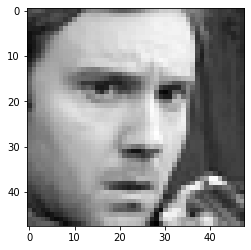

In [4]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

##  MobileNet 모델 학습하기

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Epoch 1/100
1010/1010 [==============================] - 99s 98ms/step - loss: 1.7794 - categorical_accuracy: 0.2764 - val_loss: 1.9171 - val_categorical_accuracy: 0.1471 - lr: 0.0010
Epoch 2/100
1010/1010 [==============================] - 15s 15ms/step - loss: 1.5817 - categorical_accuracy: 0.3892 - val_loss: 1.9017 - val_categorical_accuracy: 0.1471 - lr: 0.0010
Epoch 3/100
1010/1010 [==============================] - 15s 15ms/step - loss: 1.4727 - categorical_accuracy: 0.4323 - val_loss: 1.8541 - val_categorical_accuracy: 0.1471 - lr: 0.0010
Epoch 4/100
1010/1010 [==============================] - 15s 15ms/step - loss: 1.3986 - categorical_accuracy: 0.4609 - val_loss: 1.8265 - val_categorical_accuracy: 0.2641 - lr: 0.0010
Epoch 5/100
1010/1010 [==============================] - 15s 15ms/step - loss: 1.3349 - categorical_accuracy: 0.4934 - val_loss: 1.5415 - val_categorical_accuracy: 0.3957 - lr: 0.0010
Epoch 6/100
1010/1010 [==============================] - 15s 15ms/step - loss: 1

1010/1010 [==============================] - 13s 12ms/step - loss: 0.0135 - categorical_accuracy: 0.9946 - val_loss: 3.7063 - val_categorical_accuracy: 0.5801 - lr: 1.0000e-04
Epoch 88/100
1010/1010 [==============================] - 12s 12ms/step - loss: 0.0117 - categorical_accuracy: 0.9950 - val_loss: 3.8129 - val_categorical_accuracy: 0.5798 - lr: 1.0000e-04
Epoch 89/100
1010/1010 [==============================] - 13s 13ms/step - loss: 0.0117 - categorical_accuracy: 0.9952 - val_loss: 3.8338 - val_categorical_accuracy: 0.5801 - lr: 1.0000e-04
Epoch 90/100
1010/1010 [==============================] - 13s 13ms/step - loss: 0.0132 - categorical_accuracy: 0.9948 - val_loss: 3.7016 - val_categorical_accuracy: 0.5832 - lr: 1.0000e-04
Epoch 91/100
1010/1010 [==============================] - 13s 13ms/step - loss: 0.0114 - categorical_accuracy: 0.9955 - val_loss: 3.7622 - val_categorical_accuracy: 0.5865 - lr: 1.0000e-04
Epoch 92/100
1010/1010 [==============================] - 14s 13ms/s

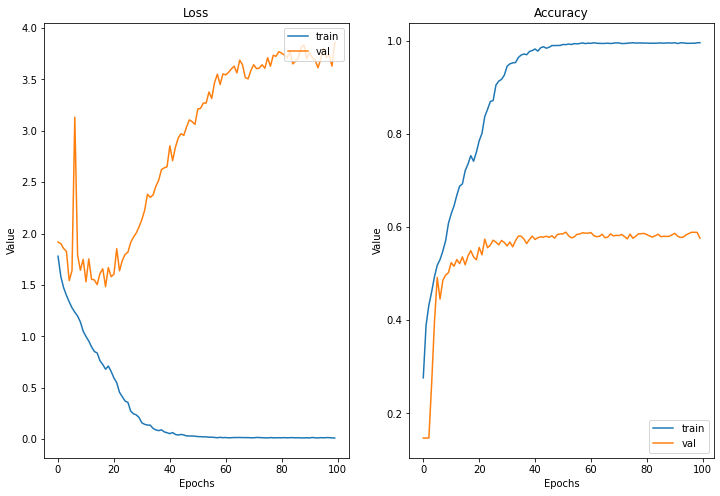

In [7]:
import tensorflow as tf

# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)

#model.fit
history = model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=100,
          batch_size=32,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)),
          callbacks=[rlp]
         )

plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy'])

In [ ]:
import os
model_path = os.getenv('HOME')+'/repo/tfjs_mobile/model.h5'
model.save(model_path)

## 마무리

### 현재 버전의 모바일 웹앱의 문제점

1. 얼굴 영역이 아닌 사진 중 임의로 설정한 부분을 검출한다.  
    - 사진에서 얼굴이 중앙이 아닌 측면에 있을 때 얼굴이 아닌 배경을 대상으로 Detect한다.
    - 학습 데이터는 얼굴 위주의 사진으로 학습했지만, 얼굴 이외의 배경이 들어가면 성능이 떨어진다.
2. 웹앱이 디자인이 사용자 친화적이지 않다.  
    - 감정의 LABELS가 한정적이다.  
    - UI가 친절하지 못하다.
3. 정확도가 50% 보다 낮다.  
    - 확률이 반도 안돼서 신빙성이 없어보인다.  

### 개선을 위한 해결 방안

1. 얼굴 영역을 인식해주는 `face_recognition` 모듈을 사용해서, 얼굴영역을 잘라준다.  
<br> 

2. 노드에서 언급된 `google-facial-expression`의 정제된 감정 데이터를 사용한다.
<br>

3. 감정 분석에 사용하는 모델을 바꿔본다.
<br>

4. 데이터 전처리에 더 신경을 쓰고, 추가로 noise 섞인 이미지를 generate한다. 

### 웹앱 url

https://pebpung.github.io/tfjs_mobile/